In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from PIL import Image
import os
from sam.sam import SAM
from sam.example.utility.bypass_bn import enable_running_stats, disable_running_stats

Evaluation Metrics: For each experiment, evaluate model performance on:
- **Target (unseen) domain accuracy:** the primary metric for domain adaptation/generalization success.
- **Source domain accuracy:** to observe if source performance drops when adapting/generalizing.
- **Domain-wise accuracy:** accuracy on each domain separately (when applicable) to see how performance
varies.
- **Worst-group accuracy:** in multi-domain scenarios, the accuracy on the worst performing domain (reflects
robustness to the most difficult domain shift).
- **Average accuracy across domains:** when relevant

# Loading Dataset (PACS)

In [2]:
DIR_PHOTO = '/home/csalt/Haider/ATML/ATML-PA 2/PACS/PACS/photo'
DIR_ART = '/home/csalt/Haider/ATML/ATML-PA 2/PACS/PACS/art_painting'
DIR_CARTOON = '/home/csalt/Haider/ATML/ATML-PA 2/PACS/PACS/cartoon'
DIR_SKETCH = '/home/csalt/Haider/ATML/ATML-PA 2/PACS/PACS/sketch'

photo_dataset = torchvision.datasets.ImageFolder(DIR_PHOTO)
art_dataset = torchvision.datasets.ImageFolder(DIR_ART)
cartoon_dataset = torchvision.datasets.ImageFolder(DIR_CARTOON)
sketch_dataset = torchvision.datasets.ImageFolder(DIR_SKETCH)

print(f"Photo Dataset: {len(photo_dataset)}")
print(f"Art Dataset: {len(art_dataset)}")
print(f"Cartoon Dataset: {len(cartoon_dataset)}")
print(f"Sketch Dataset: {len(sketch_dataset)}")

Photo Dataset: 1670
Art Dataset: 2048
Cartoon Dataset: 2344
Sketch Dataset: 3929


In [3]:
class PACSDataset(Dataset):
    def __init__(self, root_dir, domains, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        # PACS has 7 classes
        self.classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        # Collect image paths and labels
        for domain in domains:
            domain_dir = os.path.join(root_dir, domain)
            for class_name in os.listdir(domain_dir):
                if class_name in self.classes:
                    class_dir = os.path.join(domain_dir, class_name)
                    for img_name in os.listdir(class_dir):
                        if img_name.endswith('.jpg') or img_name.endswith('.png'):
                            self.samples.append((
                                os.path.join(class_dir, img_name),
                                self.class_to_idx[class_name],
                                domain
                            ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label, domain = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label, domain

In [4]:
TRAIN_DOMAINS = ['photo', 'art_painting', 'cartoon']
TEST_DOMAINS = ['sketch']

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

pacs_train = PACSDataset(
    root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',
    domains=TRAIN_DOMAINS,
    transform=transform
)
pacs_test = PACSDataset(
    root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',
    domains=TEST_DOMAINS,
    transform=transform
)

In [5]:
train_size = int(0.95 * len(pacs_train))
val_size = len(pacs_train) - train_size
pacs_train_split, pacs_val_split = random_split(pacs_train, [train_size, val_size])

BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")

# ALTERNATIVELY DO NOT CREATE A VALIDATION SPLIT
pacs_train_loader = DataLoader(pacs_train_split, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
pacs_val_loader = DataLoader(pacs_val_split, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
pacs_test_loader = DataLoader(pacs_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training on {len(pacs_train_split)} images from domains: {', '.join(TRAIN_DOMAINS)}")
print(f"Validating on {len(pacs_val_split)} images from domains: {', '.join(TRAIN_DOMAINS)}")
print(f"Testing on {len(pacs_test)} images from domain: {', '.join(TEST_DOMAINS)}")

Training on 5758 images from domains: photo, art_painting, cartoon
Validating on 304 images from domains: photo, art_painting, cartoon
Testing on 3929 images from domain: sketch


In [6]:
pacs_source_loader = DataLoader(pacs_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

pacs_photo = PACSDataset(root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',domains=['photo'],transform=transform)
pacs_photo_loader = DataLoader(pacs_photo, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

pacs_art_painting = PACSDataset(root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',domains=['art_painting'],transform=transform)
pacs_art_painting_loader = DataLoader(pacs_art_painting, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

pacs_cartoon = PACSDataset(root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',domains=['cartoon'],transform=transform)
pacs_cartoon_loader = DataLoader(pacs_cartoon, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 1) ERM Baseline

In [32]:
erm_resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(DEVICE)
erm_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [33]:
def train_model(model, dataloader, criterion, optimizer, epochs):
    max_validation_accuracy = 0.0
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels, _ in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_acc = 100. * correct / total
        avg_train_loss = running_loss / len(dataloader)
        train_accuracies.append(train_acc)
        train_losses.append(avg_train_loss)
        
        print(f"Epoch {epoch+1}")
        print(f"\tTraining Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        
        # ALTERNATIVELY DO NOT VALIDATE
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels, _ in pacs_val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * correct / total
        if val_acc >= max_validation_accuracy:
            max_validation_accuracy = val_acc
            torch.save(model.state_dict(), 'best_erm_resnet.pth')
        avg_val_loss = val_running_loss / len(pacs_val_loader)
        val_accuracies.append(val_acc)
        val_losses.append(avg_val_loss)
        
        print(f"\tValidation Loss: {avg_val_loss:.4f}, Validation Acc: {val_acc:.2f}%")
    
    return train_accuracies, train_losses, val_accuracies, val_losses


In [34]:
erm_resnet_pacs = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
erm_resnet_pacs.fc = nn.Sequential(
    nn.Dropout(p=0.25),
    nn.Linear(erm_resnet_pacs.fc.in_features, len(pacs_train.classes))
)
for m in erm_resnet_pacs.modules():
    if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
        m.eval()
        for param in m.parameters():
            param.requires_grad = False

erm_resnet_pacs = erm_resnet_pacs.to(DEVICE)
erm_resnet_pacs_criterion = torch.nn.CrossEntropyLoss()
erm_resnet_pacs_optimizer = optim.Adam(erm_resnet_pacs.parameters(), lr=0.001)

In [35]:
# ALTERNATIVE APPROACH:
# resnet_pacs.fc = torch.nn.Linear(resnet_pacs.fc.in_features, len(pacs_train.classes))

# # Freeze backbone, only train the last layer
# for param in resnet_pacs.parameters():
#     param.requires_grad = False
# for param in resnet_pacs.fc.parameters():
#     param.requires_grad = True
# resnet_pacs_optimizer = optim.Adam(resnet_pacs.fc.parameters(), lr=0.005)

In [36]:
print("Fine-tuning ResNet-50 on PACS dataset...")
resnet_pacs_train_acc, resnet_pacs_train_loss, resnet_pacs_val_acc, resnet_pacs_val_loss = train_model(
    model=erm_resnet_pacs,
    dataloader=pacs_train_loader,
    criterion=erm_resnet_pacs_criterion,
    optimizer=erm_resnet_pacs_optimizer,
    epochs=50
)
torch.save(erm_resnet_pacs.state_dict(), 'erm_resnet.pth')

Fine-tuning ResNet-50 on PACS dataset...
Epoch 1
	Training Loss: 0.6250, Train Acc: 79.65%
	Validation Loss: 0.4237, Validation Acc: 83.55%
Epoch 2
	Training Loss: 0.3266, Train Acc: 88.62%
	Validation Loss: 0.5077, Validation Acc: 82.89%
Epoch 3
	Training Loss: 0.2234, Train Acc: 92.67%
	Validation Loss: 0.6195, Validation Acc: 83.22%
Epoch 4
	Training Loss: 0.1864, Train Acc: 93.80%
	Validation Loss: 0.2281, Validation Acc: 92.43%
Epoch 5
	Training Loss: 0.1422, Train Acc: 95.43%
	Validation Loss: 0.4806, Validation Acc: 85.20%
Epoch 6
	Training Loss: 0.1078, Train Acc: 96.82%
	Validation Loss: 0.6206, Validation Acc: 84.21%
Epoch 7
	Training Loss: 0.0808, Train Acc: 97.39%
	Validation Loss: 0.4199, Validation Acc: 87.83%
Epoch 8
	Training Loss: 0.1202, Train Acc: 96.34%
	Validation Loss: 0.4338, Validation Acc: 87.17%
Epoch 9
	Training Loss: 0.0676, Train Acc: 97.86%
	Validation Loss: 0.6502, Validation Acc: 82.24%
Epoch 10
	Training Loss: 0.0924, Train Acc: 97.06%
	Validation Loss:

In [37]:
def compute_accuracy(model, dataloader):
    model.to(DEVICE)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            images, labels, _ = batch
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    return 100.0 * correct / total if total > 0 else float("nan")

## Target Domain Evaluation (Best)

In [38]:
erm_resnet_pacs.load_state_dict(torch.load('best_erm_resnet.pth'))

<All keys matched successfully>

In [39]:
sketch_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_test_loader)
print(f"ResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy_erm:.2f}%")

ResNet-50 Accuracy on PACS Sketch Domain: 63.65%


## Source Domain Evaluation (Best)

In [40]:
source_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_source_loader)
print(f"ResNet-50 Accuracy on PACS Source Domains: {source_accuracy_erm:.2f}%")

source_photo_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_photo_loader)
print(f"ResNet-50 Accuracy on PACS Art Painting Domain: {source_photo_accuracy_erm:.2f}%")

source_art_painting_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_art_painting_loader)
print(f"ResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_erm:.2f}%")

source_cartoon_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_cartoon_loader)
print(f"ResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_erm:.2f}%")

ResNet-50 Accuracy on PACS Source Domains: 98.10%
ResNet-50 Accuracy on PACS Art Painting Domain: 99.46%
ResNet-50 Accuracy on PACS Art Domain: 96.83%
ResNet-50 Accuracy on PACS Cartoon Domain: 98.25%


## Target Domain Evaluation (Last)

In [41]:
erm_resnet_pacs.load_state_dict(torch.load('erm_resnet.pth'))

<All keys matched successfully>

In [42]:
sketch_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_test_loader)
print(f"ResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy_erm:.2f}%")

ResNet-50 Accuracy on PACS Sketch Domain: 53.04%


## Source Domain Evaluation (Last)

In [43]:
source_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_source_loader)
print(f"ResNet-50 Accuracy on PACS Source Domains: {source_accuracy_erm:.2f}%")

source_photo_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_photo_loader)
print(f"ResNet-50 Accuracy on PACS Art Painting Domain: {source_photo_accuracy_erm:.2f}%")

source_art_painting_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_art_painting_loader)
print(f"ResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_erm:.2f}%")

source_cartoon_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_cartoon_loader)
print(f"ResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_erm:.2f}%")

ResNet-50 Accuracy on PACS Source Domains: 97.38%
ResNet-50 Accuracy on PACS Art Painting Domain: 98.56%
ResNet-50 Accuracy on PACS Art Domain: 96.63%
ResNet-50 Accuracy on PACS Cartoon Domain: 97.18%


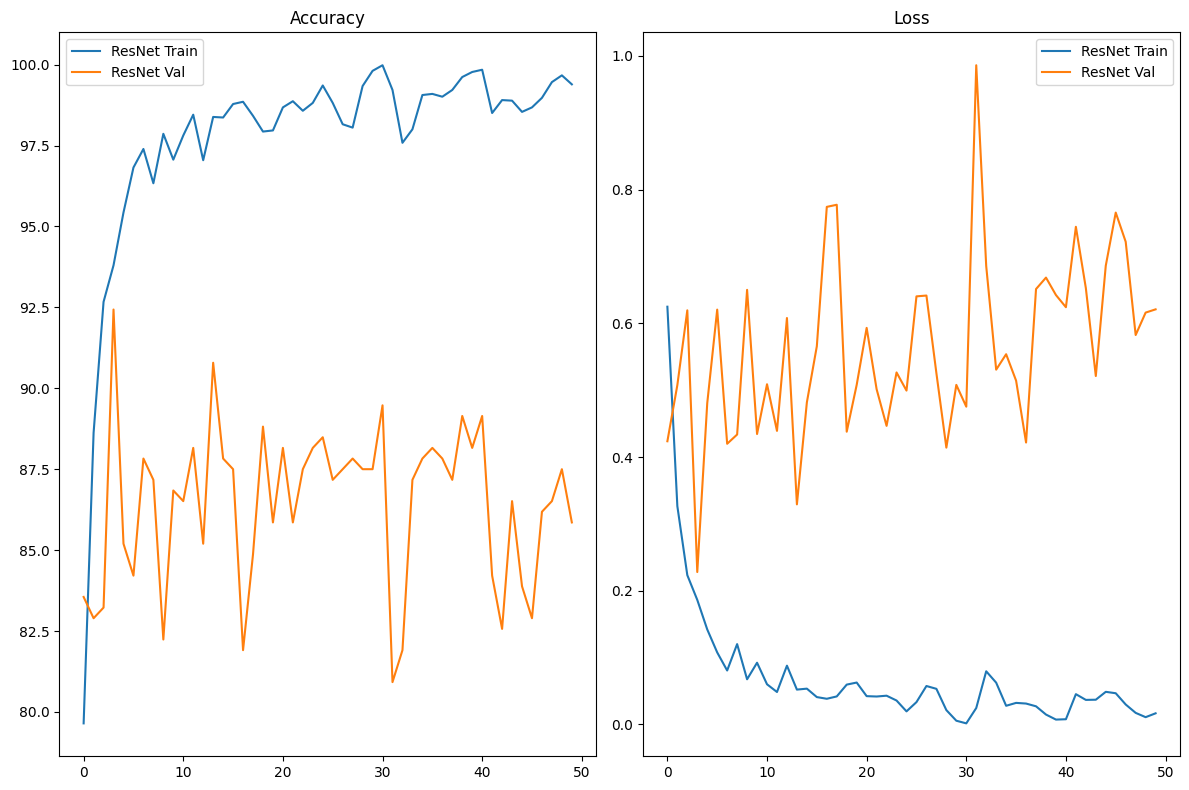

In [44]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(resnet_pacs_train_acc, label='ResNet Train')
plt.plot(resnet_pacs_val_acc, label='ResNet Val')
plt.title('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(resnet_pacs_train_loss, label='ResNet Train')
plt.plot(resnet_pacs_val_loss, label='ResNet Val')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 2) IRM

# 3) Group DRO

# 4) SAM

In [20]:
sam_resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(DEVICE)
sam_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
sam_resnet_pacs = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
sam_resnet_pacs.fc = nn.Sequential(
    nn.Dropout(p=0.25),
    nn.Linear(sam_resnet_pacs.fc.in_features, len(pacs_train.classes))
)
for m in sam_resnet_pacs.modules():
    if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
        m.eval()
        for param in m.parameters():
            param.requires_grad = False

sam_resnet_pacs = sam_resnet_pacs.to(DEVICE)
sam_resnet_pacs_criterion = torch.nn.CrossEntropyLoss()
sam_resnet_pacs_base_optimizer = optim.SGD
sam_resnet_pacs_optimizer = SAM(sam_resnet_pacs.parameters(), sam_resnet_pacs_base_optimizer, \
    rho=0.05, adaptive=False, lr=0.001, momentum=0.9, weight_decay=0.0005)
# no scheduler for SAM
EPOCHS = 50

In [ ]:
max_validation_accuracy = 0.0
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    sam_resnet_pacs.train()
    running_loss = 0.0
    correct = 0
    total = 0
        
    for images, labels, _ in pacs_train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        enable_running_stats(sam_resnet_pacs)
        outputs = sam_resnet_pacs(images)
        loss = sam_resnet_pacs_criterion(outputs, labels)
        loss.backward()
        sam_resnet_pacs_optimizer.first_step(zero_grad=True)

        # second forward-backward step
        disable_running_stats(sam_resnet_pacs)
        sam_resnet_pacs_criterion(sam_resnet_pacs(images), labels).backward()
        sam_resnet_pacs_optimizer.second_step(zero_grad=True)

        with torch.no_grad():
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    train_acc = 100. * correct / total
    avg_train_loss = running_loss / len(pacs_train_loader)
    train_accuracies.append(train_acc)
    train_losses.append(avg_train_loss)
    
    print(f"Epoch {epoch}")
    print(f"\tTraining Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    
    sam_resnet_pacs.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels, _ in pacs_val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = sam_resnet_pacs(images)
            loss = sam_resnet_pacs_criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_acc = 100. * correct / total
    if val_acc >= max_validation_accuracy:
        max_validation_accuracy = val_acc
        torch.save(sam_resnet_pacs.state_dict(), 'best_sam_resnet.pth')
    avg_val_loss = val_running_loss / len(pacs_val_loader)
    val_accuracies.append(val_acc)
    val_losses.append(avg_val_loss)
    
    print(f"\tValidation Loss: {avg_val_loss:.4f}, Validation Acc: {val_acc:.2f}%")
    
torch.save(sam_resnet_pacs.state_dict(), 'sam_resnet.pth')

Epoch 1
	Training Loss: 1.1073, Train Acc: 69.05%
	Validation Loss: 0.4865, Validation Acc: 91.12%
Epoch 2
	Training Loss: 0.3187, Train Acc: 92.62%
	Validation Loss: 0.2571, Validation Acc: 93.09%
Epoch 3
	Training Loss: 0.1768, Train Acc: 95.80%
	Validation Loss: 0.1965, Validation Acc: 93.75%
Epoch 4
	Training Loss: 0.1221, Train Acc: 97.55%
	Validation Loss: 0.1577, Validation Acc: 94.08%
Epoch 5
	Training Loss: 0.0881, Train Acc: 98.12%
	Validation Loss: 0.1476, Validation Acc: 95.07%
Epoch 6
	Training Loss: 0.0686, Train Acc: 98.71%
	Validation Loss: 0.1170, Validation Acc: 96.05%
Epoch 7
	Training Loss: 0.0536, Train Acc: 98.98%
	Validation Loss: 0.0987, Validation Acc: 97.04%
Epoch 8
	Training Loss: 0.0402, Train Acc: 99.41%
	Validation Loss: 0.0926, Validation Acc: 96.05%
Epoch 9
	Training Loss: 0.0356, Train Acc: 99.37%
	Validation Loss: 0.0841, Validation Acc: 96.71%
Epoch 10
	Training Loss: 0.0276, Train Acc: 99.72%
	Validation Loss: 0.0865, Validation Acc: 97.37%
Epoch 11


## Target Domain Evaluation (Best)

In [23]:
sam_resnet_pacs.load_state_dict(torch.load('best_sam_resnet.pth'))

<All keys matched successfully>

In [24]:
sketch_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_test_loader)
print(f"ResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy_sam:.2f}%")

ResNet-50 Accuracy on PACS Sketch Domain: 72.10%


## Source Domain Evaluation (Best)

In [25]:
source_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_source_loader)
print(f"ResNet-50 Accuracy on PACS Source Domains: {source_accuracy_sam:.2f}%")

source_photo_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_photo_loader)
print(f"ResNet-50 Accuracy on PACS Art Painting Domain: {source_photo_accuracy_sam:.2f}%")

source_art_painting_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_art_painting_loader)
print(f"ResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_sam:.2f}%")

source_cartoon_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_cartoon_loader)
print(f"ResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_sam:.2f}%")

ResNet-50 Accuracy on PACS Source Domains: 99.95%
ResNet-50 Accuracy on PACS Art Painting Domain: 100.00%
ResNet-50 Accuracy on PACS Art Domain: 99.85%
ResNet-50 Accuracy on PACS Cartoon Domain: 100.00%


## Target Domain Evaluation (Last)

In [26]:
sam_resnet_pacs.load_state_dict(torch.load('sam_resnet.pth'))

<All keys matched successfully>

In [27]:
sketch_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_test_loader)
print(f"ResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy_sam:.2f}%")

ResNet-50 Accuracy on PACS Sketch Domain: 73.07%


## Source Domain Evaluation (Last)

In [28]:
source_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_source_loader)
print(f"ResNet-50 Accuracy on PACS Source Domains: {source_accuracy_sam:.2f}%")

source_photo_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_photo_loader)
print(f"ResNet-50 Accuracy on PACS Art Painting Domain: {source_photo_accuracy_sam:.2f}%")

source_art_painting_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_art_painting_loader)
print(f"ResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_sam:.2f}%")

source_cartoon_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_cartoon_loader)
print(f"ResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_sam:.2f}%")

ResNet-50 Accuracy on PACS Source Domains: 99.92%
ResNet-50 Accuracy on PACS Art Painting Domain: 100.00%
ResNet-50 Accuracy on PACS Art Domain: 99.80%
ResNet-50 Accuracy on PACS Cartoon Domain: 99.96%


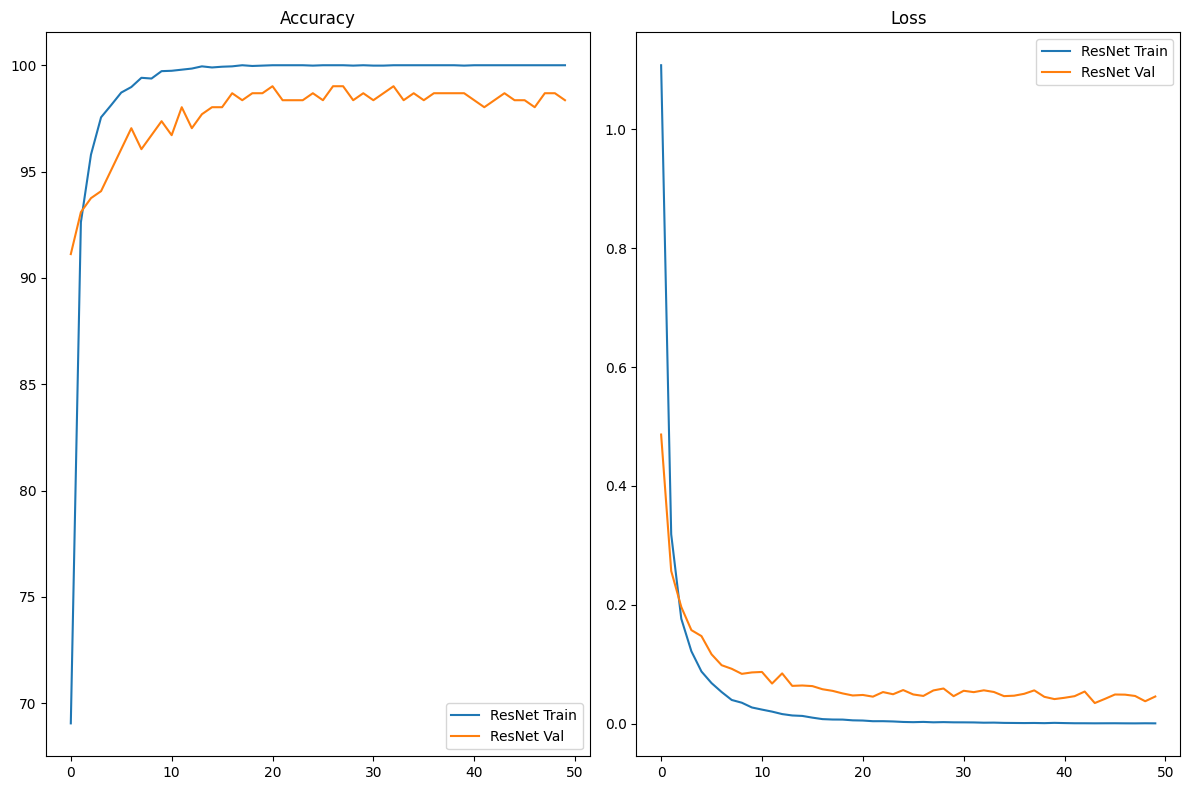

In [29]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='ResNet Train')
plt.plot(val_accuracies, label='ResNet Val')
plt.title('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_losses, label='ResNet Train')
plt.plot(val_losses, label='ResNet Val')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()